In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
dir = os.getcwd()
ROOT = os.path.dirname(dir)
sys.path.append(ROOT)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from models import resnet
from dataset import ID_OOD_dataloader

PATH = os.getcwd()

In [2]:
def load_model_param(model, model_name):
    MODEL_PATH = "models_pth/best_model_weights_" + model_name + ".pth"
    MODEL_PATH = os.path.join(PATH, MODEL_PATH)
    model_state_dict = torch.load(MODEL_PATH, weights_only=True)
    model.load_state_dict(model_state_dict)
    return model

In [3]:
model, model_name = resnet.resnet32(num_classes=100)
model.to(device)
model = load_model_param(model, model_name)

In [4]:
id_dataset, ood_dataset = ID_OOD_dataloader(bz=32)

Using downloaded and verified file: ./data\test_32x32.mat
Files already downloaded and verified
ID and OOD dataset load complete.


In [5]:
def odin_score(model, x, temperature=1, magnitude=0.00005, std=(0.2675, 0.2565, 0.2761)):
    '''
    model should return logits
    x : batch size, 3, 32, 32 => CIFAR-100(ID), SVHN(OOD)
    temperature : temperature scaling
    magnitude : perturbation magnitude (epsilon)
    std : normalized std used in training (we set 0.2675, 0.2565, 0.2761)
    '''
    model.eval()
    # Achieve Input-Preprocessing, set input required_grad=True
    x.requires_grad=True
    logits, _ = model(x)
    logits = logits / temperature
    preds = logits.argmax(dim=1)
    
    loss = F.cross_entropy(logits, preds)
    loss.backward()
    
    grad = x.grad.data
    for c in range(3):
        grad[:, c] = grad[:, c] / std[c]
    grad_sign = grad.sign()
    
    x_perturbed = x - magnitude * grad_sign
    x_perturbed = x_perturbed.detach()
    
    logits, _ = model(x_perturbed)
    logits = logits / temperature
    softmax_conf = F.softmax(logits, dim=1)
    odin_confidence, _ = torch.max(softmax_conf, dim=1)
    
    return odin_confidence


In [ ]:
def get_measures(odin_conf_id, odin_conf_ood):
    
    y_true = np.array([1] * len(odin_conf_id) + [0] * len(odin_conf_ood))
    y_score = np.concatenate((odin_conf_id, odin_conf_ood), axis=0)
    auroc = roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fpr_at_95_tpr = fpr[np.argmax(tpr >= 0.95)]
    detection_errors = 0.5 * (1 - tpr + fpr)
    detection_errors = detection_errors.min()
    
    return {
        'auroc': auroc,
        'fpr_at_95_tpr': fpr_at_95_tpr,
        'detection_errors': detection_errors
    }

In [53]:
id_x = next(iter(id_dataset))[0].to(device)
ood_x = next(iter(ood_dataset))[0].to(device)

odin_conf_id = odin_score(model, id_x, temperature=10, magnitude=0.025)
odin_conf_ood = odin_score(model, ood_x, temperature=10, magnitude=0.025)
odin_conf_id = odin_conf_id.detach().cpu().numpy()
odin_conf_ood = odin_conf_ood.detach().cpu().numpy()
measures = get_measures(odin_conf_id, odin_conf_ood)
print("AUROC: {:.4f}".format(measures['auroc']))
print("FPR at 95% TPR: {:.4f}".format(measures['fpr_at_95_tpr']))
print("Detection Errors: {:.4f}".format(measures['detection_errors']))


AUROC: 0.9717
FPR at 95% TPR: 0.0938
Detection Errors: 0.0625


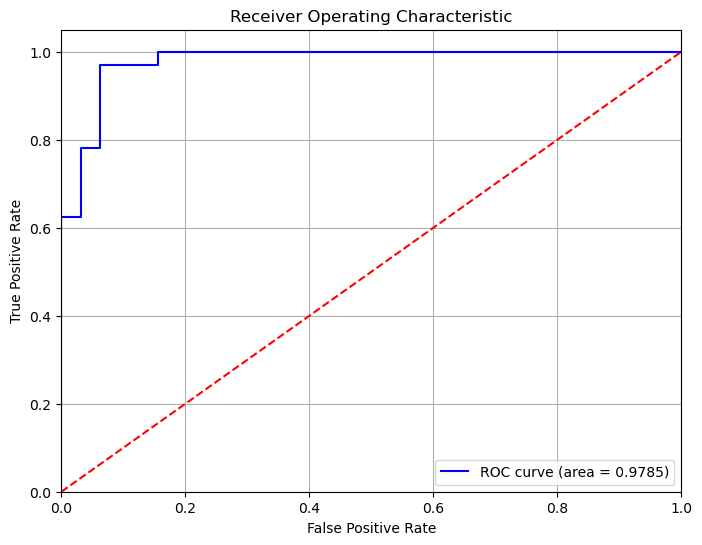

In [26]:
import matplotlib.pyplot as plt

def plot_roc_curve(odin_conf_id, odin_conf_ood):
    y_true = np.array([1] * len(odin_conf_id) + [0] * len(odin_conf_ood))
    y_score = np.concatenate((odin_conf_id, odin_conf_ood), axis=0)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.4f})'.format(measures['auroc']))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_curve(odin_conf_id, odin_conf_ood)

In [52]:
from collections import defaultdict
# 3채널 32, 32 이미지 임의 생성 후, model에 입력
x = torch.randn(1, 3, 32, 32).to(device)
logit, feats = model(x)
feat_0 = feats["feats"][0]

print(feat_0.shape)
feat_0 = F.adaptive_avg_pool2d(feat_0, 1).squeeze(-1).squeeze(-1)
print(feat_0.shape)
print(feat_0[0])
print(feat_0.size(0))


torch.Size([1, 16, 32, 32])
torch.Size([1, 16])
tensor([0.1886, 0.7212, 0.2171, 0.7248, 1.3919, 1.0970, 2.0549, 1.3997, 0.2436,
        0.4142, 1.4128, 1.6889, 0.9977, 0.5273, 1.0311, 1.5200],
       device='cuda:0', grad_fn=<SelectBackward0>)
1


In [ ]:
from collections import defaultdict

# Computing the Mahalanobis distance-based confidence score with feature ensemble, also using the Tikhonov regularization and Cholesky decomposition
def estimate_class_stats_cholesky(model, id_dataset, device, feature_layers=["feats[0]", "feats[1]", "feats[2]", "feats[3]"]):
    model.eval()
    class_means_dict = {}
    precision_dict = {}
    
    feats_by_layer = {layer: defaultdict(list) for layer in feats}
    all_feats_by_layer = {layer: [] for layer in feats}
    
    with torch.no_grad():
        for x, y in id_dataset:
            x, y = x.to(device), y.to(device)
            _, feats = model(x)
            
            for layer in feats_by_layer:
                idx = int(layer.split("[")[1].split("]")[0])
                f = feats["feats"][idx]
                # (Batch, Channel, Height, Width) 이렇게 들어감
                # Squeeze로 (Batch, Channel)
                f = F.adaptive_avg_pool2d(f, 1).squeeze(-1).squeeze(-1)
                for i in range(f.size(0)):
                    vec = f[i].cpu()
                    label = y[i].item()
                    feats_by_layer[layer][label].append(vec)
                    all_feats_by_layer[layer].append(vec)
    
    for layer in feature_layers:
        # Per Class Average
        class_means = {}
        for cls, vecs in feats_by_layer[layer].item():
            mat = torch.stack(vecs)
            class_means[cls] = mat.mean(dim=0)
        class_means_dict[layer] = class_means
        
        # Total Covariance and precision
        all_feats = torch.stack(all_feats_by_layer[layer])
                
    
    

In [ ]:
def estimate_class_stats_cholesky(model, dataloader, device, feature_layers=["feats[0]", "feats[1]", "feats[2]", "feats[3]"]):
    model.eval()
    class_means_dict = {}
    precision_dict = {}

    feats_by_layer = {layer: defaultdict(list) for layer in feature_layers}
    all_feats_by_layer = {layer: [] for layer in feature_layers}

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            _, feats = model(x)

            for layer in feature_layers:
                idx = int(layer.split("[")[1].split("]")[0])
                f = feats["feats"][idx]
                f = F.adaptive_avg_pool2d(f, 1).squeeze(-1).squeeze(-1)
                for i in range(f.size(0)):
                    vec = f[i].cpu()
                    label = y[i].item()
                    feats_by_layer[layer][label].append(vec)
                    all_feats_by_layer[layer].append(vec)

    for layer in feature_layers:
        # 클래스별 평균
        class_means = {}
        for cls, vecs in feats_by_layer[layer].items():
            mat = torch.stack(vecs)
            class_means[cls] = mat.mean(dim=0)
        class_means_dict[layer] = class_means

        # 전체 공분산 및 precision
        all_feats = torch.stack(all_feats_by_layer[layer])
        mean = all_feats.mean(dim=0, keepdim=True)
        diff = all_feats - mean
        cov = diff.T @ diff / (diff.shape[0] - 1)
        cov += 1e-6 * torch.eye(cov.shape[0])  # 안정성
        L = torch.linalg.cholesky(cov)
        precision = torch.cholesky_inverse(L)
        precision_dict[layer] = precision

    return class_means_dict, precision_dict

def mahalanobis_best_layer_score_cholesky(model, x, class_means_dict, precision_dict, feature_layers=["feats[0]", "feats[1]", "feats[2]", "feats[3]"]):
    model.eval()
    with torch.no_grad():
        _, feats = model(x)
        all_layer_scores = []

        for layer in feature_layers:
            idx = int(layer.split("[")[1].split("]")[0])
            feat = feats["feats"][idx]  # [B, C, H, W]
            feat = F.adaptive_avg_pool2d(feat, 1).squeeze(-1).squeeze(-1)  # [B, C]

            class_means = class_means_dict[layer]
            precision = precision_dict[layer]  # [C, C]

            scores = []
            for f in feat:
                min_dist = float("inf")
                for c in class_means:
                    delta = (f - class_means[c]).unsqueeze(0)
                    dist = torch.matmul(torch.matmul(delta, precision), delta.T).item()
                    if dist < min_dist:
                        min_dist = dist
                scores.append(min_dist)

            all_layer_scores.append(torch.tensor(scores))

        # [L, B] → [B] (최소 거리 선택 → 부호 반전)
        all_layer_scores = torch.stack(all_layer_scores, dim=0)
        best_scores = -torch.min(all_layer_scores, dim=0).values

    return best_scores.cpu().numpy()


In [ ]:
def estimate_mean_precision(model, dataloader, layer='avgpool'):
    from collections import defaultdict
    model.eval()
    features = defaultdict(list)
    with torch.no_grad():
        for x, y in dataloader:
            x = x.cuda()
            feat = extract_features(model, x, layer)
            for f, label in zip(feat, y):
                features[label.item()].append(f.cpu().numpy())
    
    class_means = {}
    all_feats = []
    for c in features:
        class_feats = np.stack(features[c])
        class_means[c] = class_feats.mean(axis=0)
        all_feats.append(class_feats)
    
    all_feats = np.concatenate(all_feats, axis=0)
    cov = np.cov(all_feats.T) + 1e-6 * np.eye(all_feats.shape[1])  # regularize
    precision = np.linalg.inv(cov)

    return class_means, precision
